# CRCD Tutorial

Thank you for having interest in CRCD! This is the official tutorial of accessing the dataset. Here, we will go through some basics usage of CRCD, including the following:

* Load the stereo endoscope calibration data
* Extract frames with the desired timestamps
* Convert stereo endoscopic images to point clouds

## Load Libraries

In [1]:
#! /usr/bin/env python3

# Import ROS libraries
import rospy
import rosbag
from sensor_msgs.msg import CameraInfo, JointState
from geometry_msgs.msg import TransformStamped

# Import basic libraries
import numpy as np
from tqdm.notebook import tqdm
import cv2
import open3d as o3d
from open3d.web_visualizer import draw
from PIL import Image
import pickle
import random
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

# For extracting text in images
# import pytesseract
import tesserocr

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Open3D INFO] Resetting default logger to print to terminal.


## Stereo Endoscope Calibration Data

In [2]:
# Load Stereo Calibration Results
# Refer to https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html for further details.

def load_stereo_calib(calib_path):
    with open(calib_path, "rb") as f:
        calib_data = pickle.load(f)
    Q = calib_data["ecm_Q"].astype(np.float32)
    R = calib_data["ecm_R"].astype(np.float32)
    T = calib_data["ecm_T"].astype(np.float32)
    f = Q[2,3]
    B = -1/Q[3,2]
    return Q, R, T, B.astype(np.float32), f.astype(np.float32)

calib_path = "/home/leo/ecm_si_calib_data/30/1280x720/ECM_STEREO_1280x720_L2R_calib_data_opencv.pkl"
Q, _, _, _, _ = load_stereo_calib(calib_path) 

## Extract Timestamp from Videos

In [3]:
# Function for extracting the time
def extract_ros_time(frame):
    # the timestamp is located on the bottom of the image
    bottom = frame[720:,:,:]
    
    # Convert the image to gray scale
    gray = cv2.cvtColor(bottom, cv2.COLOR_BGR2GRAY)
     
    # Performing OTSU threshold
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
    
    # Cleaning up the threshold image
    # You can tune the size of the kernel if necessary
    kernel = np.ones((3,3),np.uint8)
    morph_close = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    morph_pil = Image.fromarray(morph_close)

    # Return the extracted text from the image
    # It will return an empty string if not detected
    # return pytesseract.image_to_string(morph_close).strip()
    return tesserocr.image_to_text(morph_pil).strip()

In [4]:
# Extract the frame with the desired timestamp
def get_des_ts_frame(video_path, des_ts):
    # Load the video
    video_cap  = cv2.VideoCapture(video_path)
    
    # Total number of frames in the video
    total_frames = np.int32(video_cap.get(cv2.CAP_PROP_FRAME_COUNT))

    print("Processing {}...".format(video_path))
    with tqdm(total=total_frames) as pbar:
        while video_cap.isOpened():
            ret, frame = video_cap.read()
            if ret:
                # You may need to convert the color.
                pbar.update(1)
                rostime = extract_ros_time(frame)
                if str(des_ts) == rostime:
                    print("Found the image for timestamp {}...".format(des_ts))
                    break
            else:
                print("Failed to find the image for timestamp {}...".format(des_ts))
                break
    video_cap.release()
    return frame[:720,:,:]

Processing /home/leo/sitl_dvrk_record/C_3/left/left.mp4...


  0%|          | 0/57907 [00:00<?, ?it/s]

Found the image for timestamp 1700682785.3666139...
Processing /home/leo/sitl_dvrk_record/C_3/right/right.mp4...


  0%|          | 0/57907 [00:00<?, ?it/s]

Found the image for timestamp 1700682785.3672035...


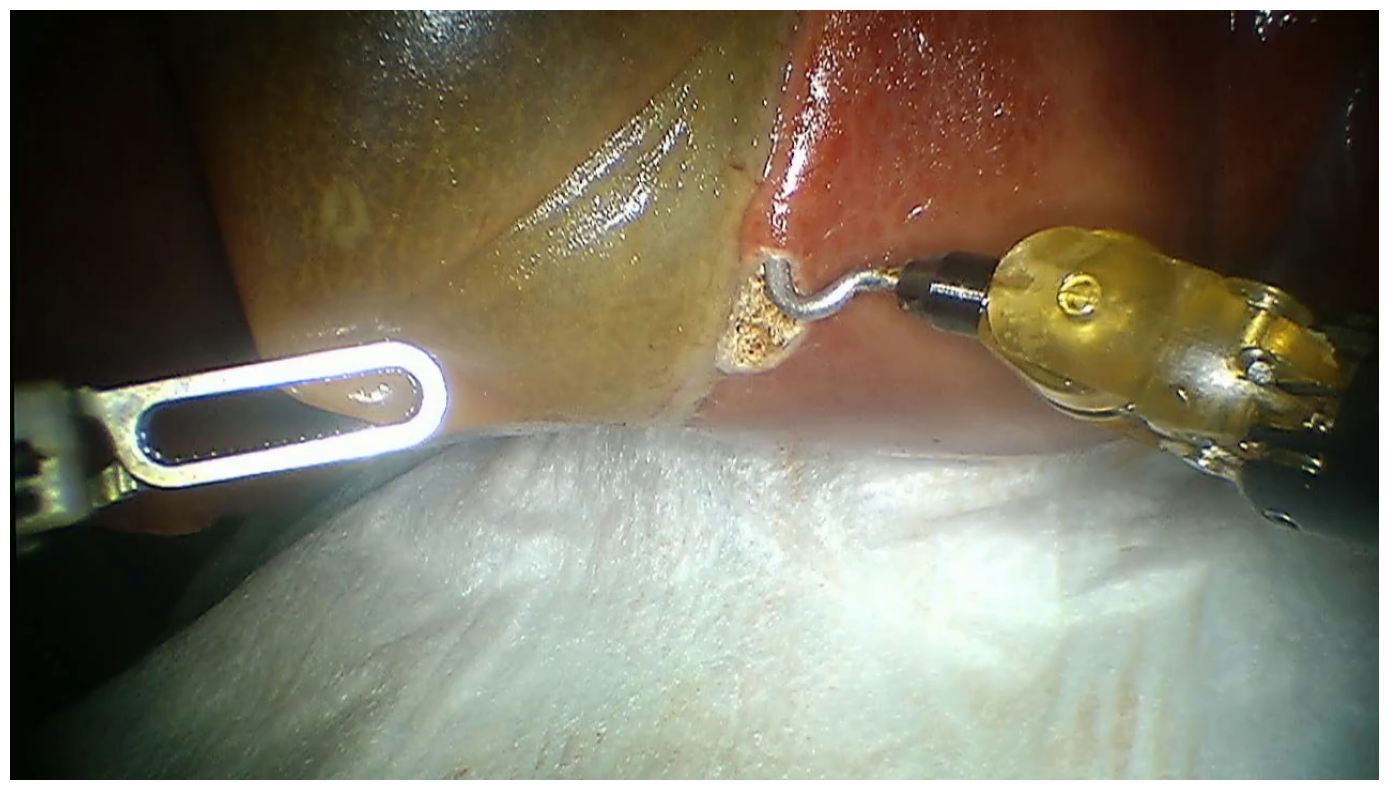

In [5]:
# extract endoscope frames with your desired timestamp

# Load the video
left_video_path = "/home/leo/sitl_dvrk_record/C_3/left/left.mp4"
right_video_path = "/home/leo/sitl_dvrk_record/C_3/right/right.mp4"

# Desired Timestamp
left_des_ts = 1700682785.3666139
right_des_ts = 1700682785.3672035

left_rect_color = get_des_ts_frame(left_video_path, left_des_ts)
right_rect_color = get_des_ts_frame(right_video_path, right_des_ts)

plt.imshow(left_rect_color[:,:,::-1])
plt.gca().set_axis_off()

## Convert Stereo Images to Point Clouds

To convert stereo images to point clouds, it is recommended to build OpenCV with CUDA. 
You may use the CPU version but the function parameters and the results could be different.

In [6]:
# parameters used in point cloud generation functions
stereo_params = {
    "min_disp"   : 0,
    "sgm_ndisp"  : 256,
    "P1"         : 30,
    "P2"         : 210,
    "uniq_ratio" : 5,
    "bf_size"    : 5,
    "depth_scale": 1000,
    "depth_trunc": 0.15,
    "pcl_scale"  : 15,
}

In [7]:
# Convert CPU mat OpenCV images to GPU mat
def cvmat2gpumat(image):
    image_cuda = cv2.cuda_GpuMat()
    image_cuda.upload(image)
    return image_cuda

# Generate SGM node for the first camera
# (left camera if it is calibrated left to right)
def cam1_stereo_sgm(params):
    return cv2.cuda.createStereoSGM(
        minDisparity    = params["min_disp"],
        numDisparities  = params["sgm_ndisp"], 
        P1              = params["P1"],
        P2              = params["P2"],
        uniquenessRatio = params["uniq_ratio"],
        mode            = cv2.StereoSGBM_MODE_HH
    )

# Use the SGM to generate the disparity map from the stereo images
def cuda_sgm(cam1_sgm, cam1_rect_mono_cuda, cam2_rect_mono_cuda):
    disp_sgm_cuda = cv2.cuda_GpuMat()
    disp_sgm_cuda = cam1_sgm.compute(cam1_rect_mono_cuda,cam2_rect_mono_cuda,disp_sgm_cuda)
    disp_sgm_cuda = cv2.cuda.normalize(disp_sgm_cuda, alpha=0, beta=65535, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32FC1)
    return disp_sgm_cuda

# Apply Bilateral Filter to clean the image
def apply_bf(img_cuda, kernel_size):
    return cv2.cuda.bilateralFilter(
        img_cuda,
        kernel_size=kernel_size,
        sigma_color=kernel_size*2,
        # sigma_spatial=int(kernel_size/2)
        sigma_spatial=int(kernel_size**3)
    )

# Scales the disparity map
def scale_disp_cuda(disp_cuda):
    disp_cv = np.float32(disp_cuda.download()/16)
    disp_cuda.upload(disp_cv)
    return disp_cuda

# Converts disparity map to point cloud
def disp2pcl2_cuda(ref_img_cv, disp_cuda, Q, params):
    n_points = ref_img_cv.shape[:2]
    pcl_cv2_cuda = cv2.cuda.reprojectImageTo3D(disp_cuda, Q, dst_cn=3)
    pcl_cv2      = pcl_cv2_cuda.download()/params["depth_scale"]*params["pcl_scale"]
    trunc_idx    = np.where(pcl_cv2[:,:,2] < params["depth_trunc"])
    return pcl_cv2[trunc_idx], ref_img_cv[trunc_idx]

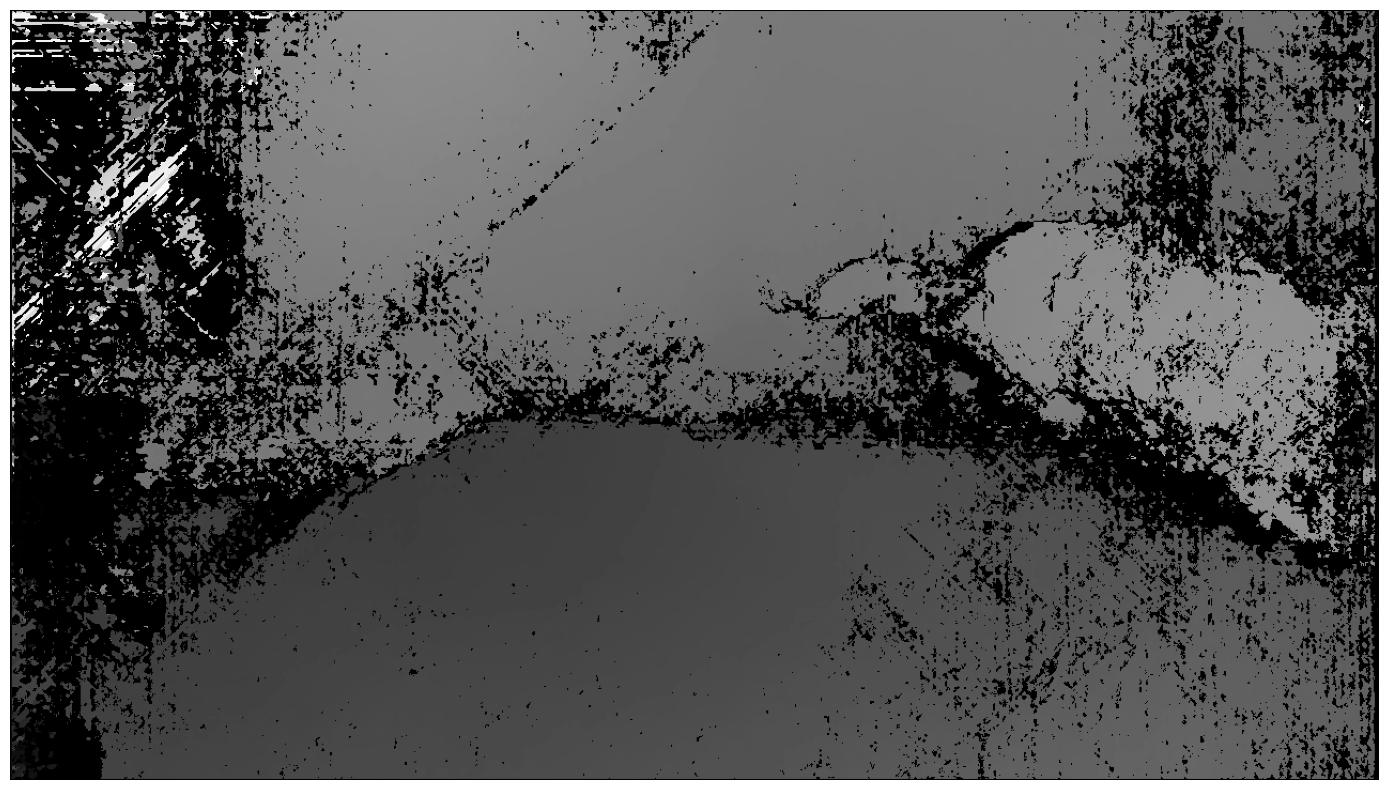

In [8]:
# Load SGM for first camera
cam1_sgm = cam1_stereo_sgm(stereo_params)

# Convert to gray scale images
left_rect_gray = cv2.cvtColor(left_rect_color, cv2.COLOR_BGR2GRAY)
right_rect_gray = cv2.cvtColor(right_rect_color, cv2.COLOR_BGR2GRAY)

# Convert to GPU Mat images
left_rect_gray_cuda = cvmat2gpumat(left_rect_gray)
right_rect_gray_cuda = cvmat2gpumat(right_rect_gray)

# Generate the disparity map
disp_cuda = cuda_sgm(cam1_sgm, left_rect_gray_cuda, right_rect_gray_cuda)

# Apply bilateral filter
disp_cuda = apply_bf(disp_cuda, stereo_params['bf_size'])

# Scale the disparity map
disp_cuda = scale_disp_cuda(disp_cuda)

# Display the disparity map
plt.imshow(disp_cuda.download(), cmap='gray')
plt.gca().set_axis_off()

In [9]:
# Convert to point clouds (Open 3D for visualization)
points, colors = disp2pcl2_cuda(left_rect_color, disp_cuda, Q, stereo_params)

In [57]:
# Generate the point clouds and visualize in a separate window
# -- Mouse view control --
#   Left button + drag         : Rotate.
#   Ctrl + left button + drag  : Translate.
#   Wheel button + drag        : Translate.
#   Shift + left button + drag : Roll.
#   Wheel                      : Zoom in/out.

# -- Keyboard view control --
#   [/]          : Increase/decrease field of view.
#   R            : Reset view point.
#   Ctrl/Cmd + C : Copy current view status into the clipboard.
#   Ctrl/Cmd + V : Paste view status from clipboard.

# -- General control --
#   Q, Esc       : Exit window.
#   H            : Print help message.
#   P, PrtScn    : Take a screen capture.
#   D            : Take a depth capture.
#   O            : Take a capture of current rendering settings.

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)
pcd.colors = o3d.utility.Vector3dVector(colors[:,::-1]/255)
o3d.visualization.draw_geometries([pcd],
                                  zoom=1000,
                                  front=[0.4257, -0.2125, -0.8795],
                                  lookat=[2.6172, 2.0475, 1.532],
                                  up=[-0.0694, -0.9768, 0.2024])

EGL(1.5)
OpenGL(4.1)
[Open3D INFO]   -- Mouse view control --
[Open3D INFO]     Left button + drag         : Rotate.
[Open3D INFO]     Ctrl + left button + drag  : Translate.
[Open3D INFO]     Wheel button + drag        : Translate.
[Open3D INFO]     Shift + left button + drag : Roll.
[Open3D INFO]     Wheel                      : Zoom in/out.
[Open3D INFO] 
[Open3D INFO]   -- Keyboard view control --
[Open3D INFO]     [/]          : Increase/decrease field of view.
[Open3D INFO]     R            : Reset view point.
[Open3D INFO]     Ctrl/Cmd + C : Copy current view status into the clipboard.
[Open3D INFO]     Ctrl/Cmd + V : Paste view status from clipboard.
[Open3D INFO] 
[Open3D INFO]   -- General control --
[Open3D INFO]     Q, Esc       : Exit window.
[Open3D INFO]     H            : Print help message.
[Open3D INFO]     P, PrtScn    : Take a screen capture.
[Open3D INFO]     D            : Take a depth capture.
[Open3D INFO]     O            : Take a capture of current rendering s